<a href="https://colab.research.google.com/github/michalinahulak/Enzyme_Stability/blob/main/Enzyme_Stability_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost

In [ ]:
!pip install optuna

In [ ]:
!pip install biopython

In [ ]:
! pip install fair-esm

# Introduction
In this data science project, we aim to predict enzyme stability using machine learning and deep learning models. Our goal is to build a predictive model that can accurately predict enzyme stability based on their pH and protein sequence.

# Imports

In [5]:
import pandas as pd
import numpy as np

#visualization
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import ElasticNetCV
 
import math

import re

from pathlib import Path
import zipfile

from Bio.SeqUtils.ProtParam import ProteinAnalysis

from esm import FastaBatchedDataset, pretrained

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import RidgeCV

import optuna

from Bio.Seq import Seq

from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset

from PIL import Image

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!ls -la '/content/drive/MyDrive/Colab Notebooks/Codecool/Projekt końcowy'

total 628467
drwx------ 2 root root      4096 Apr 27 10:58  catboost_info
-rw------- 1 root root  10228181 May 14 08:15  data_filtered.fasta
drwx------ 2 root root      4096 Mar 25 10:19  datasets
-rw------- 1 root root 472622418 Apr 21 12:24  df_krammer.csv
-rw------- 1 root root  14421517 May  4 18:59  enzyme_stability_dataset.csv
-rw------- 1 root root    541477 May 15 18:16  Enzyme_Stability_Prediction.ipynb
-rw------- 1 root root    185768 May  4 18:53 'Kopia notatnika Novozymes_Enzyme_Stability_Prediction.ipynb'
drwx------ 2 root root      4096 May 14 19:21  lightning_logs
-rw------- 1 root root    153629 May  4 10:44  Novozymes_Enzyme_Stability_Prediction.ipynb
-rw------- 1 root root    551619 May 14 11:45  protein_model.pth
-rw------- 1 root root     58442 May  2 20:23  submission.csv
-rw------- 1 root root 144772013 May 13 20:35  train_embeddings.zip


In [8]:
%cd /content/drive/MyDrive/Colab Notebooks/Codecool/Projekt końcowy

/content/drive/MyDrive/Colab Notebooks/Codecool/Projekt końcowy


# Functions

In [ ]:
def heatmap(df, title):
  ax = sns.heatmap(df.corr(),
                 xticklabels=df.corr().columns,
                 yticklabels=df.corr().columns,
                 cmap='Blues', 
                 vmin=-1, vmax=1,
                 annot=True, 
                 center=0
                 )


  plt.title(f'{title}', fontsize=20)
  bottom, top = ax.get_ylim()
  ax.set_ylim(bottom +0.25, top -0.25)
  plt.show()

In [ ]:
def scatter_plot(data, x_col, y_col):
    plt.scatter(data[x_col], data[y_col], alpha=0.5)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(f'Relationship between {y_col} and {x_col}')
    plt.show()

In [9]:
def calculate_isoelectric_point (sequence):
    protein_analysis = ProteinAnalysis(sequence)
    return protein_analysis.isoelectric_point()

In [ ]:
def get_kmer_counts(seq):
    kmer_counts = {}
    for i in range(len(seq) - k + 1):
        kmer = seq[i:i+k]
        if kmer in kmer_counts:
            kmer_counts[kmer] += 1
        else:
            kmer_counts[kmer] = 1
    return kmer_counts

In [ ]:
def return_amino_acid(df):
  amino_acids=['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
  for amino_acid in amino_acids:
    df[amino_acid]=df['protein_sequence'].str.count(amino_acid,re.I)/df['protein_length']
  return df

Function below was found in [this](https://www.kaggle.com/code/viktorfairuschin/extracting-esm-2-embeddings-from-fasta-files) notebook on Kaggle. Thank you, Viktor Fairuschin, for sharing.

In [ ]:
def extract_embeddings(model_name, fasta_file, output_dir, tokens_per_batch=4108, seq_length=1027,repr_layers=[33]):
    
    model, alphabet = pretrained.load_model_and_alphabet(model_name)
    model.eval()

    if torch.cuda.is_available():
        model = model.cuda()
        
    dataset = FastaBatchedDataset.from_file(fasta_file)
    batches = dataset.get_batch_indices(tokens_per_batch, extra_toks_per_seq=1)

    data_loader = torch.utils.data.DataLoader(
        dataset, 
        collate_fn=alphabet.get_batch_converter(seq_length), 
        batch_sampler=batches
    )

    output_dir.mkdir(parents=True, exist_ok=True)
    
    with torch.no_grad():
        for batch_idx, (labels, strs, toks) in enumerate(data_loader):

            print(f'Processing batch {batch_idx + 1} of {len(batches)}')

            if torch.cuda.is_available():
                toks = toks.to(device="cuda", non_blocking=True)

            out = model(toks, repr_layers=repr_layers, return_contacts=False)

            logits = out["logits"].to(device="cpu")
            representations = {layer: t.to(device="cpu") for layer, t in out["representations"].items()}
            
            for i, label in enumerate(labels):
                entry_id = label.split()[0]
                
                filename = output_dir / f"{entry_id}.pt"
                truncate_len = min(seq_length, len(strs[i]))

                result = {"entry_id": entry_id}
                result["mean_representations"] = {
                        layer: t[i, 1 : truncate_len + 1].mean(0).clone()
                        for layer, t in representations.items()
                    }

                torch.save(result, filename)

# Loading dataset


In [32]:
url = 'https://github.com/michalinahulak/Novozymes_Enzyme_Stability/raw/main/enzyme_stability_dataset.csv'
data = pd.read_csv(url)
data.head()

,seq_id,protein_sequence,pH,data_source,tm
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5


# Preprocessing

## Missing values
Missing values ​​are only in train dataset.

*   'data_source' - 980 missing values
*   'pH' - 286 missing values

'data_source' will be not use in modelling so it can contains missing values. 
Column 'pH' is very important and missing values ​​account less than 1% of all values, therefore rows containing missing values ​​in the 'pH' column will be deleted.

In [ ]:
# missing values df_train

data.isnull().sum().sort_values(ascending = False)

data_source         980
pH                  286
protein_sequence      0
tm                    0
dtype: int64

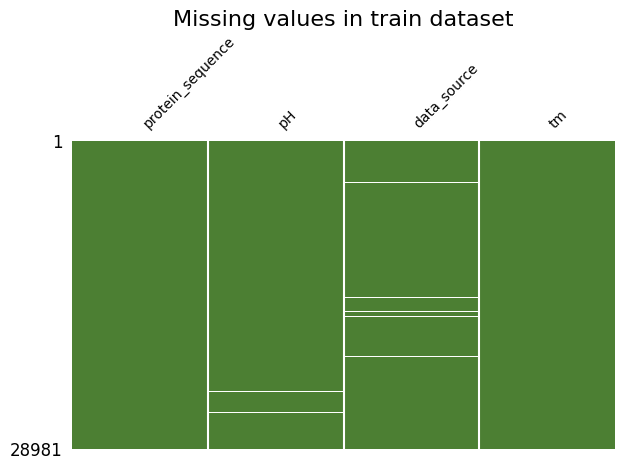

In [ ]:
msno.matrix(data, figsize=(7,4), color = (0.3, 0.5, 0.2), fontsize = 10, sparkline = False)
plt.title('Missing values in train dataset', fontdict = {'fontsize':16})
plt.show(); 

In [33]:
# remove rows with missing values in 'pH' column and remove 'data_source' column

data = data.dropna(subset=['pH'])\
        .drop('data_source', axis=1)

## Feature extractions

In [34]:
scaler = MinMaxScaler()

data['protein_length'] = data['protein_sequence'].apply(lambda x: len(x))
data['protein_length_normalized'] = scaler.fit_transform(data[['protein_length']])
data['isoelectric_point'] = data['protein_sequence'].apply(calculate_isoelectric_point) 
# data['pH_normalized'] = scaler.fit_transform(data[['pH']])
# data['isoelectric_point_normalized'] = scaler.fit_transform(data[['isoelectric_point']])
data.head(3)

,seq_id,protein_sequence,pH,tm,protein_length,protein_length_normalized,isoelectric_point
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7,341,0.038212,6.109589
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5,286,0.031957,5.144349
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5,497,0.055954,9.032101


In [ ]:
max_protein_length = data['protein_length'].max()
min_protein_length = data['protein_length'].min()

print('Max protein_length: ', max_protein_length)
print('Min protein_length: ', min_protein_length)

Max protein_length:  8798
Min protein_length:  5


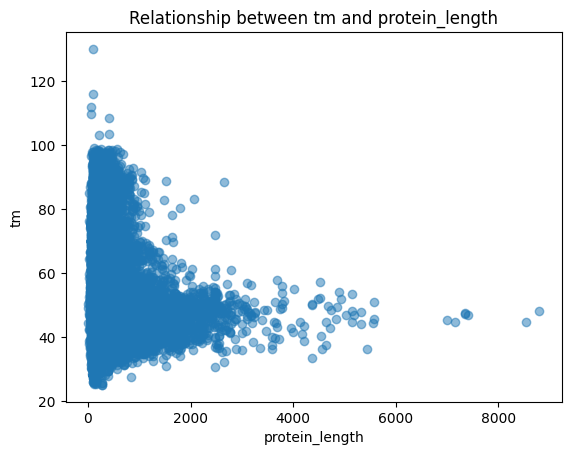

In [ ]:
scatter_plot(data, 'protein_length', 'tm')

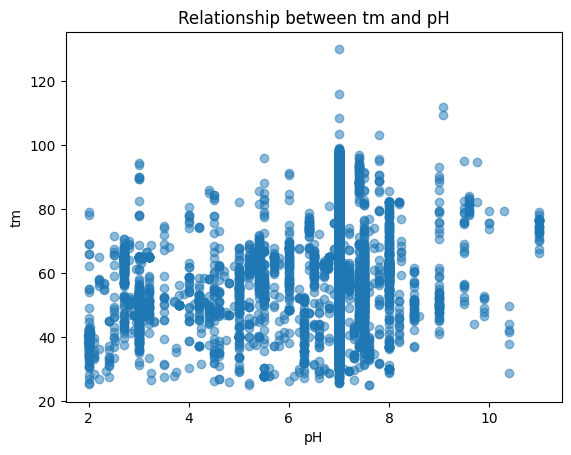

In [ ]:
scatter_plot(data, 'pH', 'tm')

<ipython-input-90-ebe98e1357b5>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  ax = sns.heatmap(df.corr(),
<ipython-input-90-ebe98e1357b5>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  xticklabels=df.corr().columns,
<ipython-input-90-ebe98e1357b5>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  yticklabels=df.corr().columns,


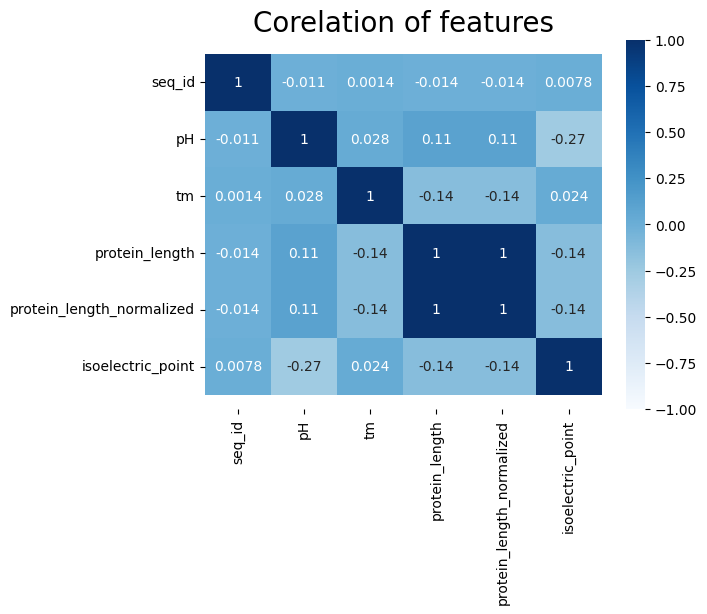

In [ ]:
heatmap(data, 'Corelation of features')

## Outliers

In [ ]:
data.describe()

,seq_id,pH,tm,protein_length,protein_length_normalized
count,28695.000000,28695.000000,28695.000000,28695.000000,28695.000000
mean,15631.432166,6.872467,51.385604,451.729535,0.050805
std,9235.099078,0.793184,12.076609,416.889872,0.047412
min,0.000000,1.990000,25.100000,5.000000,0.000000
25%,7447.500000,7.000000,43.700000,210.000000,0.023314
50%,15443.000000,7.000000,48.800000,352.000000,0.039463
75%,23758.500000,7.000000,54.600000,537.000000,0.060503
max,31389.000000,11.000000,130.000000,8798.000000,1.000000


The length of protein sequences varies greatly, ranging from 5 to over 8000. 

In [35]:
df_filtered = data.copy()

Q1 = df_filtered['tm'].quantile(0.25)
Q3 = df_filtered['tm'].quantile(0.75)
IQR = Q3 - Q1

Q1 = df_filtered['protein_length'].quantile(0.25)
Q3 = df_filtered['protein_length'].quantile(0.75)
IQR = Q3 - Q1

mask = (df_filtered['tm'] >= Q1 - 1.5*IQR) & (df_filtered['tm'] <= Q3 + 1.5*IQR) & \
       (df_filtered['protein_length'] >= Q1 - 1.5*IQR) & (df_filtered['protein_length'] <= Q3 + 1.5*IQR)

df_filtered = df_filtered[mask]

In [ ]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26872 entries, 0 to 28980
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   seq_id                     26872 non-null  int64  
 1   protein_sequence           26872 non-null  object 
 2   pH                         26872 non-null  float64
 3   tm                         26872 non-null  float64
 4   protein_length             26872 non-null  int64  
 5   protein_length_normalized  26872 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 1.4+ MB


In [ ]:
df_filtered.describe()

,seq_id,pH,tm,protein_length,protein_length_normalized,isoelectric_point
count,26872.000000,26872.000000,26872.000000,26872.000000,26872.000000,26872.000000
mean,15648.308425,6.865970,51.673768,372.991776,0.041851,6.799377
std,9224.068360,0.812791,12.300812,215.055413,0.024458,1.732985
min,0.000000,1.990000,25.100000,5.000000,0.000000,4.050028
25%,7455.750000,7.000000,43.700000,200.000000,0.022177,5.401262
50%,15498.500000,7.000000,49.000000,334.000000,0.037416,6.174329
75%,23730.250000,7.000000,55.000000,487.000000,0.054816,8.522994
max,31389.000000,11.000000,130.000000,1027.000000,0.116229,11.999968


In [ ]:
with open('data_filtered.fasta', 'w') as f:
    for row in df_filtered.itertuples(index=False):
        f.write(f'>{row.seq_id}\n{row.protein_sequence}\n')


## K-mer counting

In [ ]:
df_kmer = data.copy()

In [ ]:
k = 3

kmer_counts = df_kmer['protein_sequence'].apply(get_kmer_counts)

# zamiana kmer_counts na dataframe z odpowiednią nazwą kolumny i odpowiednim indeksem
kmer_counts_df = pd.DataFrame.from_records(kmer_counts).fillna(0).astype(int)
kmer_counts_df.columns = [f"kmer_{k}_{kmer}" for kmer in kmer_counts_df.columns]
kmer_counts_df.index = df_kmer.index

# połączenie oryginalnego dataframe'u z kmer_counts_df
df_kmer = pd.concat([df_kmer, kmer_counts_df], axis=1)

In [ ]:
df_kmer.head(3)

,protein_sequence,pH,tm,protein_length,protein_length_normalized,kmer_3_AAA,kmer_3_AAK,kmer_3_AKA,kmer_3_KAA,kmer_3_AAL,...,kmer_3_CMY,kmer_3_WMH,kmer_3_CWP,kmer_3_MCM,kmer_3_WCC,kmer_3_HMW,kmer_3_WHC,kmer_3_CWW,kmer_3_WKW,kmer_3_WCW
seq_id,,,,,,,,,,,,,,,,,,,,,
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7,341,0.038212,3,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5,286,0.031957,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5,497,0.055954,4,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


##Amino acid

### all dataset

In [ ]:
df_amino = data.copy()

In [ ]:
df_amino = return_amino_acid(df_amino)
df_amino.head(3)

,seq_id,protein_sequence,pH,tm,protein_length,protein_length_normalized,molecular_weight,molecular_weight_normalized,A,C,...,M,N,P,Q,R,S,T,V,W,Y
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7,341,0.038212,36320.7244,0.035463,0.131965,0.002933,...,0.023460,0.014663,0.052786,0.017595,0.073314,0.032258,0.041056,0.108504,0.011730,0.008798
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5,286,0.031957,32837.9931,0.032013,0.097902,0.000000,...,0.006993,0.020979,0.027972,0.076923,0.104895,0.048951,0.041958,0.045455,0.010490,0.010490
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5,497,0.055954,53428.8034,0.052414,0.100604,0.018109,...,0.012072,0.030181,0.040241,0.050302,0.062374,0.066398,0.060362,0.060362,0.006036,0.032193


### df_filtered

In [ ]:
df_filtered_amino = df_filtered.copy()
df_filtered_amino = return_amino_acid(df_filtered_amino)
df_filtered_amino.head(3)

,seq_id,protein_sequence,pH,tm,protein_length,protein_length_normalized,molecular_weight,molecular_weight_normalized,isoelectric_point,A,...,M,N,P,Q,R,S,T,V,W,Y
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7,341,0.038212,36320.7244,0.035463,6.109589,0.131965,...,0.023460,0.014663,0.052786,0.017595,0.073314,0.032258,0.041056,0.108504,0.011730,0.008798
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5,286,0.031957,32837.9931,0.032013,5.144349,0.097902,...,0.006993,0.020979,0.027972,0.076923,0.104895,0.048951,0.041958,0.045455,0.010490,0.010490
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5,497,0.055954,53428.8034,0.052414,9.032101,0.100604,...,0.012072,0.030181,0.040241,0.050302,0.062374,0.066398,0.060362,0.060362,0.006036,0.032193


## ESM

In [ ]:
model_name = 'esm2_t33_650M_UR50D'
fasta_file = 'data_filtered.fasta'
output_dir = Path('train_embeddings')

extract_embeddings(model_name, fasta_file, output_dir)

In [ ]:
# If you use colab you can save train_embeddings as .zip file in your google drive

# !zip -r train_embeddings.zip train_embeddings
# !cp train_embeddings.zip "/content/drive/My Drive/"

In [36]:
# You can upload train_embeddings.zip and unpack it

zip_file = 'train_embeddings.zip'
output_dir = '/content/embeddings'

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

In [ ]:
path = '/content/embeddings/train_embeddings/0.pt'
embedding = torch.load(path)

# show embedding
print(embedding)

{'entry_id': '0', 'mean_representations': {33: tensor([ 0.0705, -0.1038, -0.0003,  ..., -0.0874, -0.0014,  0.0459])}}


In [15]:
# convert train_embeddings to dataframe

embeddings_dir = Path('/content/embeddings/train_embeddings')

embedding_files = list(embeddings_dir.glob('*.pt'))

embedding_list = []
for embedding_file in embedding_files:
    embedding = torch.load(embedding_file)['mean_representations'][33]
    entry_id = torch.load(embedding_file)['entry_id']
    embedding_dict = {'entry_id': entry_id, 'embedding': embedding}
    embedding_list.append(embedding_dict)

df = pd.DataFrame(embedding_list)
df['entry_id'] = df['entry_id'].astype(int)
df.sort_values(by='entry_id', inplace=True)
df = df.rename(columns={'entry_id': 'seq_id'})

df.head(3)

,seq_id,embedding
17085,0,"[tensor(0.0705), tensor(-0.1038), tensor(-0.00..."
14356,1,"[tensor(0.0653), tensor(-0.0039), tensor(-0.04..."
15819,2,"[tensor(-4.7959e-05), tensor(-0.0171), tensor(..."


In [38]:
df_embedding_filtered = (df[['seq_id', 'embedding']]
                         .merge(df_filtered,
                                on='seq_id', 
                                how='inner')
                         .drop(['protein_sequence', 'protein_length'], axis=1))
df_embedding_filtered.head(3)

,seq_id,embedding,pH,tm,protein_length_normalized,isoelectric_point
0,0,"[tensor(0.0705), tensor(-0.1038), tensor(-0.00...",7.0,75.7,0.038212,6.109589
1,1,"[tensor(0.0653), tensor(-0.0039), tensor(-0.04...",7.0,50.5,0.031957,5.144349
2,2,"[tensor(-4.7959e-05), tensor(-0.0171), tensor(...",7.0,40.5,0.055954,9.032101


# Models for k-mer set



In [ ]:
models = {
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    # 'ElasticNetCV': ElasticNetCV(l1_ratio = 0.5, cv=10, random_state=0),
    # 'XGBRegressor': XGBRegressor(learning_rate=0.1, max_depth=20, n_estimators=250, random_state=8),
    'CatBoostRegressor' : CatBoostRegressor(iterations=1000,
                           learning_rate=0.1,
                           depth=10,
                           loss_function='RMSE'),
    # 'LGBMRegressor': LGBMRegressor(objective= "regression", metric = "rmse", num_leaves = 1024, max_depth = 500, 
    #                            learning_rate = 0.1,)

}

In [ ]:
# split df
X = df_kmer.drop(['seq_id','protein_sequence', 'tm', 'protein_length'], axis=1)
y = df_kmer['tm']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [ ]:
results_kmer = pd.DataFrame()

for name, model in models.items():
    model.fit(X_train, y_train.values.ravel())
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test)
    results = pd.DataFrame({
        'Model': [name],
        'MSE_train': [mean_squared_error(y_train, y_pred_train)],
        'MSE_val': [mean_squared_error(y_val, y_pred_val)],
        'MSE_test': [mean_squared_error(y_test, y_pred_test)],
        'MAE_train': [mean_absolute_error(y_train, y_pred_train)],
        'MAE_val': [mean_absolute_error(y_val, y_pred_val)],
        'MAE_test': [mean_absolute_error(y_test, y_pred_test)],
        'R^2_train': [r2_score(y_train, y_pred_train)],
        'R^2_val': [r2_score(y_val, y_pred_val)],
        'R^2_test': [r2_score(y_test, y_pred_test)]
    })
    results_kmer = pd.concat([results_kmer, results], ignore_index=True)

In [ ]:
results_kmer

,Model,MSE_train,MSE_val,MSE_test,MAE_train,MAE_val,MAE_test,R^2_train,R^2_val,R^2_test
0,RandomForest,14.024573,91.734142,89.817641,2.625676,6.733020,6.712207,0.905334,0.372586,0.350883
1,CatBoostRegressor,15.797424,75.840777,75.214817,2.924441,6.501065,6.440109,0.893367,0.481288,0.456418


# Models for amino acid set

In [ ]:
models = {
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'ElasticNetCV': ElasticNetCV(l1_ratio = 0.5, cv=10, random_state=0),
    'XGBRegressor': XGBRegressor(learning_rate=0.1, max_depth=20, n_estimators=250, random_state=8),
    'CatBoostRegressor' : CatBoostRegressor(iterations=1000,
                           learning_rate=0.1,
                           depth=10,
                           loss_function='RMSE'),
    'LGBMRegressor': LGBMRegressor(objective= "regression", metric = "rmse", num_leaves = 1024, max_depth = 500, 
                               learning_rate = 0.1,),
    'RidgeCV' : RidgeCV()

}

## all dataset

In [ ]:
# split X, y for df_train_amino

X = df_amino.drop(['seq_id', 'protein_sequence', 'tm', 'protein_length'], axis=1)
y = df_amino['tm']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [ ]:
results_aminoacid = pd.DataFrame()

for name, model in models.items():
    model.fit(X_train, y_train.values.ravel())
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test)
    results = pd.DataFrame({
        'Model': [name],
        'MSE_train': [mean_squared_error(y_train, y_pred_train)],
        'MSE_val': [mean_squared_error(y_val, y_pred_val)],
        'MSE_test': [mean_squared_error(y_test, y_pred_test)],
        'MAE_train': [mean_absolute_error(y_train, y_pred_train)],
        'MAE_val': [mean_absolute_error(y_val, y_pred_val)],
        'MAE_test': [mean_absolute_error(y_test, y_pred_test)],
        'R^2_train': [r2_score(y_train, y_pred_train)],
        'R^2_val': [r2_score(y_val, y_pred_val)],
        'R^2_test': [r2_score(y_test, y_pred_test)]
    })
    results_aminoacid = pd.concat([results_aminoacid, results], ignore_index=True)


In [ ]:
results_aminoacid

,Model,MSE_train,MSE_val,MSE_test,MAE_train,MAE_val,MAE_test,R^2_train,R^2_val,R^2_test
0,RandomForest,9.430715,56.848431,57.305677,2.191390,5.469111,5.487334,0.936342,0.611186,0.585849
1,ElasticNetCV,110.048820,110.775761,105.493884,8.104656,8.099073,7.942555,0.257167,0.242351,0.237590
2,XGBRegressor,1.620910,61.202542,61.162252,0.226129,5.629194,5.580040,0.989059,0.581406,0.557977
3,CatBoostRegressor,5.334928,54.148302,54.427956,1.506547,5.391396,5.385877,0.963989,0.629653,0.606646
4,LGBMRegressor,4.043535,55.859857,56.982782,1.009341,5.459793,5.476191,0.972706,0.617947,0.588182


## filtered data

In [ ]:
df_filtered_amino.head(3)

,seq_id,protein_sequence,pH,tm,protein_length,protein_length_normalized,molecular_weight,molecular_weight_normalized,isoelectric_point,A,...,M,N,P,Q,R,S,T,V,W,Y
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7,341,0.038212,36320.7244,0.035463,6.109589,0.131965,...,0.023460,0.014663,0.052786,0.017595,0.073314,0.032258,0.041056,0.108504,0.011730,0.008798
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5,286,0.031957,32837.9931,0.032013,5.144349,0.097902,...,0.006993,0.020979,0.027972,0.076923,0.104895,0.048951,0.041958,0.045455,0.010490,0.010490
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5,497,0.055954,53428.8034,0.052414,9.032101,0.100604,...,0.012072,0.030181,0.040241,0.050302,0.062374,0.066398,0.060362,0.060362,0.006036,0.032193


In [ ]:
X = df_filtered_amino.drop(['seq_id',	'protein_sequence', 'tm', 'protein_length'], axis=1)
y = df_filtered_amino['tm']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [ ]:
results_filtered_aminoacid = pd.DataFrame()

for name, model in models.items():
    model.fit(X_train, y_train.values.ravel())
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test)
    results = pd.DataFrame({
        'Model': [name],
        'MSE_train': [mean_squared_error(y_train, y_pred_train)],
        'MSE_val': [mean_squared_error(y_val, y_pred_val)],
        'MSE_test': [mean_squared_error(y_test, y_pred_test)],
        'MAE_train': [mean_absolute_error(y_train, y_pred_train)],
        'MAE_val': [mean_absolute_error(y_val, y_pred_val)],
        'MAE_test': [mean_absolute_error(y_test, y_pred_test)],
        'R^2_train': [r2_score(y_train, y_pred_train)],
        'R^2_val': [r2_score(y_val, y_pred_val)],
        'R^2_test': [r2_score(y_test, y_pred_test)]
    })
    results_filtered_aminoacid = pd.concat([results_filtered_aminoacid, results], ignore_index=True)

In [ ]:
results_filtered_aminoacid

,Model,MSE_train,MSE_val,MSE_test,MAE_train,MAE_val,MAE_test,R^2_train,R^2_val,R^2_test
0,RandomForest,9.959821,57.940179,60.131315,2.225169,5.607841,5.700010,0.934890,0.618301,0.587339
1,ElasticNetCV,118.333692,116.415428,117.043314,8.284225,8.202961,8.325385,0.226416,0.233077,0.196770
2,XGBRegressor,1.817231,59.491060,63.727129,0.244239,5.641808,5.787173,0.988120,0.608084,0.562662
3,CatBoostRegressor,4.993440,55.364115,58.387872,1.400873,5.536607,5.654937,0.967356,0.635271,0.599303
4,LGBMRegressor,4.203817,58.723742,60.195176,1.016494,5.661891,5.720341,0.972518,0.613139,0.586900
5,RidgeCV,111.819371,108.546811,112.397011,8.203759,8.075496,8.299346,0.269002,0.284914,0.228656


## Optuna
searching for the best hyperparameters for CatBoostRegressor

In [ ]:
# split X, y for df_train_amino

X = df_filtered_amino.drop(['protein_sequence', 'tm', 'protein_length'], axis=1)
y = df_filtered_amino['tm']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [ ]:
def catboost_objective(trial):
    # Define the hyperparameters to optimize
    params = {
        'iterations': trial.suggest_int('iterations', 500, 2000, step=500),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'depth': trial.suggest_int('depth', 5, 15),
        'loss_function': 'RMSE',
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0, 10),
        'random_seed': 42,
        'silent': True
    }

    # Train the model and make predictions
    model = CatBoostRegressor(**params)
    model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=10, verbose=False)
    y_pred = model.predict(X_val)

    # Compute the loss
    loss = mean_squared_error(y_val, y_pred, squared=False)

    return loss

study = optuna.create_study(direction='minimize')
study.optimize(catboost_objective, n_trials=10)

print('Best hyperparameters:', study.best_params)
print('Best accuracy:', study.best_value)

In [ ]:
# [I 2023-05-02 19:24:08,844] Trial 8 finished with value: 7.208425679872539 and parameters: {'iterations': 1000, 'learning_rate': 0.035290781378874744, 'depth': 11}. Best is trial 8 with value: 7.208425679872539.
print('Best hyperparameters:', study.best_params)
print('Best accuracy:', study.best_value)

In [ ]:
model = CatBoostRegressor(iterations=1000,
                           learning_rate=0.035290781378874744,
                           depth=11)

In [ ]:
model.fit(X_train, y_train.values.ravel())
y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)
y_pred_val = model.predict(X_val)
y_pred_test = model.predict(X_test)
results = pd.DataFrame({
        'Model': [name],
        'MSE_train': [mean_squared_error(y_train, y_pred_train)],
        'MSE_val': [mean_squared_error(y_val, y_pred_val)],
        'MSE_test': [mean_squared_error(y_test, y_pred_test)],
        'MAE_train': [mean_absolute_error(y_train, y_pred_train)],
        'MAE_val': [mean_absolute_error(y_val, y_pred_val)],
        'MAE_test': [mean_absolute_error(y_test, y_pred_test)],
        'R^2_train': [r2_score(y_train, y_pred_train)],
        'R^2_val': [r2_score(y_val, y_pred_val)],
        'R^2_test': [r2_score(y_test, y_pred_test)]})


In [ ]:
results

,Model,MSE_train,MSE_val,MSE_test,MAE_train,MAE_val,MAE_test,R^2_train,R^2_val,R^2_test
0,XGBRegressor,11.733814,53.161637,53.456715,2.471989,5.351472,5.364638,0.920796,0.636402,0.613665


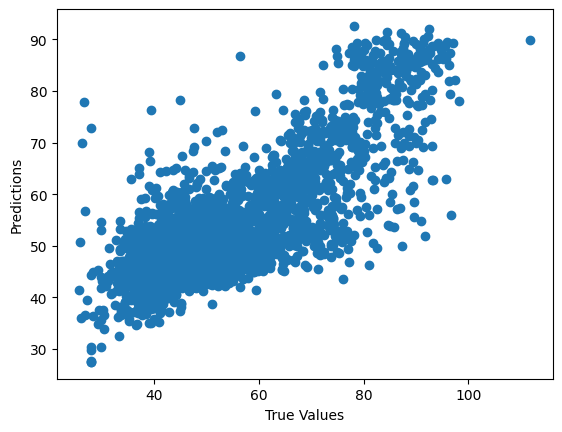

In [ ]:
plt.scatter(y_test, y_pred_test)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

# transfer learning

In [ ]:
df_tl = data.copy()

In [ ]:
# Tworzenie słownika przypisującego aminokwasom wartości pikseli
aa_to_pixel = {
    'A': [255, 255, 255],  # Biały
    'R': [255, 0, 0],      # Czerwony
    'N': [255, 255, 0],    # Żółty
    'D': [255, 128, 0],    # Pomarańczowy
    'C': [0, 255, 0],      # Zielony
    'E': [128, 128, 128],  # Szary
    'Q': [0, 255, 255],    # Jasnoniebieski
    'G': [0, 0, 255],      # Niebieski
    'H': [255, 0, 255],    # Fioletowy
    'I': [0, 128, 0],      # Ciemnozielony
    'L': [0, 128, 128],    # Ciemnoniebieski
    'K': [0, 0, 128],      # Granatowy
    'M': [128, 0, 128],    # Purpurowy
    'F': [128, 0, 0],      # Ciemnoczerwony
    'P': [192, 192, 192],  # Srebrny
    'S': [128, 128, 0],    # Oliwkowy
    'T': [0, 128, 128],    # Turkusowy
    'W': [0, 0, 0],        # Czarny
    'Y': [255, 255, 128],  # Jasnobeżowy
    'V': [128, 128, 128]   # Szary
}


# Przetwarzanie sekwencji białkowych na obrazy o wymiarach (64, 64, 3)
images = []
for sequence in df_tl['protein_sequence']:
    seq = Seq(sequence)
    seq_len = len(seq)
    img = Image.new('RGB', (64, 64), color = 'white')
    pixels = img.load()
    for i, aa in enumerate(seq):
        if i >= 501:
            break
        pixel = tuple(aa_to_pixel[aa])
        pixels[i % 64, i // 64] = pixel
    img = img_to_array(img)
    images.append(img)


In [ ]:
X = np.array(images)
y = df_tl['tm'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [ ]:
# Wczytanie wytrenowanego modelu ResNet50V2
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Zamrożenie wag wstępnie wytrenowanych warstw
for layer in base_model.layers:
    layer.trainable = False

# Dodanie warstwy wyjściowej
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='linear')(x)

# Stworzenie nowego modelu z wykorzystaniem wstępnie wytrenowanego ResNet50V2
model = Model(inputs=base_model.input, outputs=x)

# Kompilacja modelu
model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error', metrics=['mae'])

# Trenowanie modelu
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)


94668760/94668760 [==============================] - 1s 0us/step


Epoch 1/10
539/539 [==============================] - 370s 676ms/step - loss: 39671.8516 - mae: 49.2949 - val_loss: 199.8835 - val_mae: 9.6470
Epoch 2/10
539/539 [==============================] - 337s 625ms/step - loss: 688.6287 - mae: 20.9217 - val_loss: 211.7474 - val_mae: 10.0400
Epoch 3/10
539/539 [==============================] - 336s 623ms/step - loss: 685.4400 - mae: 20.8043 - val_loss: 299.5166 - val_mae: 13.0908
Epoch 4/10
539/539 [==============================] - 327s 608ms/step - loss: 733.4373 - mae: 21.3188 - val_loss: 245.2379 - val_mae: 11.2432
Epoch 5/10
539/539 [==============================] - 314s 583ms/step - loss: 698.8620 - mae: 21.1049 - val_loss: 183.3719 - val_mae: 9.2247
Epoch 6/10
539/539 [==============================] - 325s 603ms/step - loss: 690.1578 - mae: 20.9536 - val_loss: 258.0143 - val_mae: 11.7493
Epoch 7/10
539/539 [==============================] - 314s 582ms/step - loss: 671.2824 - mae: 20.6941 - val_loss: 186.2126 - val_mae: 9.3672
Epoch 8

In [ ]:
loss_test, mae_test = model.evaluate(X_test, y_test)
print(f'Test loss: {loss_test}, Test MAE {mae_test}')

180/180 [==============================] - 93s 515ms/step - loss: 137.2951 - mae: 7.9567
Test loss: 137.29513549804688, Test MAE 7.956679344177246


# Models for ESM

In [39]:
df_embedding_filtered.head(3)


,seq_id,embedding,pH,tm,protein_length_normalized,isoelectric_point
0,0,"[tensor(0.0705), tensor(-0.1038), tensor(-0.00...",7.0,75.7,0.038212,6.109589
1,1,"[tensor(0.0653), tensor(-0.0039), tensor(-0.04...",7.0,50.5,0.031957,5.144349
2,2,"[tensor(-4.7959e-05), tensor(-0.0171), tensor(...",7.0,40.5,0.055954,9.032101


In [40]:
tensor_list = [torch.tensor(embedding) for embedding in df_embedding_filtered['embedding']]
embeddings_tensor = torch.stack(tensor_list)

<ipython-input-40-e799f2e8c63c>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_list = [torch.tensor(embedding) for embedding in df_embedding_filtered['embedding']]


In [41]:
X = df_embedding_filtered[["pH", "protein_length_normalized", "isoelectric_point"]]
X = torch.cat((embeddings_tensor, torch.tensor(X.values)), dim=1)
y = df_embedding_filtered['tm'].values

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [43]:
class ProteinModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, dropout=0.2):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out.squeeze()

epochs = 10
batch_size = 32
lr = 0.001
hidden_size = 64
dropout = 0.2

class ProteinDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]
        return X, y

train_dataset = ProteinDataset(X_train, torch.tensor(y_train))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = ProteinDataset(X_val, torch.tensor(y_val))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model = ProteinModel(X.shape[1], hidden_size, dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train_losses, val_losses = [], []
for epoch in range(epochs):
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch.float())
        loss = criterion(output, y_batch.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            output = model(X_batch.float())
            loss = criterion(output, y_batch.float())
            val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

    print(f"Epoch {epoch+1}, train loss: {train_loss:.4f}, val loss: {val_loss:.4f}")


with torch.no_grad():
    train_preds = model(X_train.float())
    train_mse = mean_squared_error(y_train, train_preds.numpy())
    train_mae = mean_absolute_error(y_train, train_preds.numpy())
    train_r2 = r2_score(y_train, train_preds.numpy())

    val_preds = model(X_val.float())
    val_mae = mean_absolute_error(y_val, val_preds.numpy())
    val_mse = mean_squared_error(y_val, val_preds.numpy())
    val_r2 = r2_score(y_val, val_preds.numpy())
    
    metrics = pd.DataFrame({
        'Dataset': ['Train', 'Val'],
        'MAE': [train_mae, val_mae],
        'MSE': [train_mse, val_mse],
        'R^2': [train_r2, val_r2]
    })
    print(metrics)


Epoch 1, train loss: 447.6709, val loss: 102.0418
Epoch 2, train loss: 97.9933, val loss: 88.8182
Epoch 3, train loss: 91.7706, val loss: 85.4040
Epoch 4, train loss: 87.6230, val loss: 81.8761
Epoch 5, train loss: 85.7590, val loss: 79.7235
Epoch 6, train loss: 84.8543, val loss: 80.2450
Epoch 7, train loss: 82.6846, val loss: 77.3843
Epoch 8, train loss: 82.1519, val loss: 78.9960
Epoch 9, train loss: 82.3282, val loss: 78.4190
Epoch 10, train loss: 80.0601, val loss: 80.1497
  Dataset       MAE        MSE       R^2
0   Train  6.867438  81.112395  0.469743
1     Val  6.869684  78.877765  0.480368


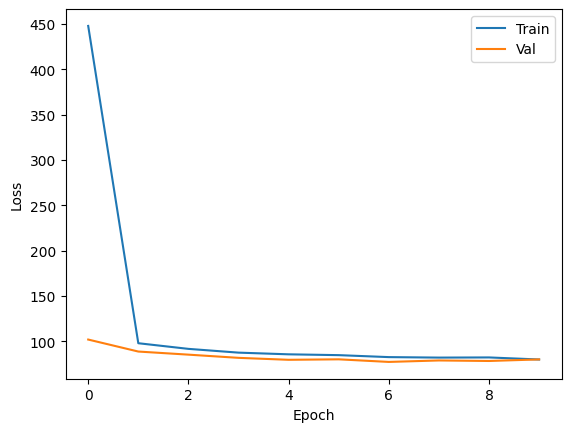

In [44]:
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Optuna

In [45]:
def objective(trial):

    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    hidden_size = trial.suggest_int('hidden_size', 32, 128)
    dropout = trial.suggest_uniform('dropout', 0.0, 0.5)
    
    model = ProteinModel(X.shape[1], hidden_size, dropout)
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    criterion = nn.MSELoss()
    
    for epoch in range(epochs):
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch.float())
            loss = criterion(output, y_batch.float())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                output = model(X_batch.float())
                loss = criterion(output, y_batch.float())
                val_loss += loss.item()
            val_loss /= len(val_loader)
            
        trial.report(val_loss, epoch)
        
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    return val_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=200)

print('Best trial:')
trial = study.best_trial
print(f'  Loss: {trial.value:.4f}')
print('  Params:')
for key, value in trial.params.items():
    print(f'    {key}: {value}')


[I 2023-05-15 19:22:55,208] A new study created in memory with name: no-name-e998146a-8eb4-462b-99f9-827ccdaf558d
<ipython-input-45-26f7d6af7739>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
<ipython-input-45-26f7d6af7739>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  dropout = trial.suggest_uniform('dropout', 0.0, 0.5)
[I 2023-05-15 19:23:15,014] Trial 0 finished with value: 232.1947892961048 and parameters: {'lr': 1.9732650020906635e-05, 'hidden_size': 127, 'dropout': 0.3081888836545807}. Best is trial 0 with value: 232.1947892961048.
[I 2023-05-15 19:23:29,260] Trial 1 finished with value: 

Best trial:
  Loss: 46.9586
  Params:
    lr: 0.005940956244695846
    hidden_size: 93
    dropout: 0.0012791862150734602


In [46]:
# model after tunning

class ProteinModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, dropout=0.2):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out.squeeze()

epochs = 10
batch_size = 32
lr = 0.005940956244695846
hidden_size = 93
dropout = 0.0012791862150734602

class ProteinDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]
        return X, y

train_dataset = ProteinDataset(X_train, torch.tensor(y_train))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = ProteinDataset(X_val, torch.tensor(y_val))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model = ProteinModel(X.shape[1], hidden_size, dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train_losses, val_losses = [], []
for epoch in range(epochs):
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch.float())
        loss = criterion(output, y_batch.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            output = model(X_batch.float())
            loss = criterion(output, y_batch.float())
            val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

    print(f"Epoch {epoch+1}, train loss: {train_loss:.4f}, val loss: {val_loss:.4f}")

with torch.no_grad():
    train_preds = model(X_train.float())
    train_mse = mean_squared_error(y_train, train_preds.numpy())
    train_mae = mean_absolute_error(y_train, train_preds.numpy())
    train_r2 = r2_score(y_train, train_preds.numpy())

    val_preds = model(X_val.float())
    val_mae = mean_absolute_error(y_val, val_preds.numpy())
    val_mse = mean_squared_error(y_val, val_preds.numpy())
    val_r2 = r2_score(y_val, val_preds.numpy())
    
    metrics = pd.DataFrame({
        'Dataset': ['Train', 'Val'],
        'MAE': [train_mae, val_mae],
        'MSE': [train_mse, val_mse],
        'R^2': [train_r2, val_r2]
    })
    display(metrics)


Epoch 1, train loss: 140.4415, val loss: 60.2858
Epoch 2, train loss: 63.2223, val loss: 57.2088
Epoch 3, train loss: 60.6299, val loss: 56.6362
Epoch 4, train loss: 59.9864, val loss: 55.4577
Epoch 5, train loss: 57.5026, val loss: 53.8376
Epoch 6, train loss: 56.7831, val loss: 56.3093
Epoch 7, train loss: 54.8063, val loss: 51.1707
Epoch 8, train loss: 52.9446, val loss: 54.1349
Epoch 9, train loss: 52.7050, val loss: 52.7720
Epoch 10, train loss: 52.0582, val loss: 51.8115


,Dataset,MAE,MSE,R^2
0,Train,5.264949,49.539616,0.676144
1,Val,5.466371,51.649605,0.659742


In [ ]:
torch.save(model.state_dict(), 'protein_model.pth')

In [47]:
# test set
with torch.no_grad():
    test_preds = model(X_test.float())
    test_mae = mean_absolute_error(y_test, test_preds.numpy())
    test_mse = mean_squared_error(y_test, test_preds.numpy())
    test_r2 = r2_score(y_test, test_preds.numpy())
    print(f"Test MAE: {test_mae:.4f}")
    print(f"Test MSE: {test_mse:.4f}")
    print(f"Test R^2: {test_r2:.4f}")

Test MAE: 5.5790
Test MSE: 55.6766
Test R^2: 0.6179


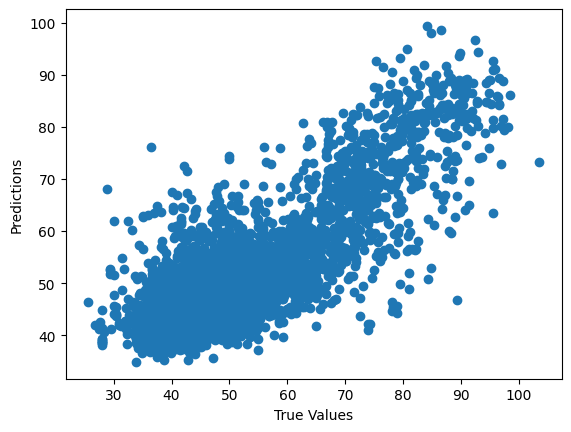

In [ ]:
plt.scatter(y_test, test_preds.numpy())
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()